In [7]:
""" Resize the notbook to full width, to fit more code and images """
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

""" some basic packages and settings to show images inline """
import numpy as np
import torch
import torch.distributions as dstr
import itertools
import torchvision
import torchvision.transforms as transforms
from tools import Dataset_to_XY, DataXY

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

""" Controls for figure sizes to change """
import matplotlib
plt.rcParams.update({'errorbar.capsize': 1})
# VoMi: Configure figure fonts
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['cmr10']  # This sets the Computer Modern Roman font
matplotlib.rcParams['text.usetex'] = False  # Ensure LaTeX is not being used for rendering
matplotlib.rcParams['axes.unicode_minus'] = False

# Alternatively, you can specify other font properties if needed
matplotlib.rcParams['font.size'] = 14  # Set the global font size
matplotlib.rcParams['axes.titlesize'] = 14  # Set the axes title font size
matplotlib.rcParams['axes.labelsize'] = 12  # Set the axes labels font size
matplotlib.rcParams['xtick.labelsize'] = 12  # Set the x-tick labels font size
matplotlib.rcParams['ytick.labelsize'] = 12  # Set the y-tick labels font size
matplotlib.rcParams['legend.fontsize'] = 12  # Set the legend font size

""" Lab support code """
import lab

def save_jpg(file_name):
    plt.savefig(file_name, bbox_inches='tight', dpi=300, pad_inches=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# query if we have GPU
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {dev}')

# Global datasets
transform = transforms.Compose([transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,)),
                    transforms.Lambda(torch.flatten)]) 
# training and validation sets
train_set = Dataset_to_XY(torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform))
train_set, val_set = train_set.split(valid_size=0.1)
# test set
test_set = Dataset_to_XY(torchvision.datasets.MNIST('./data', download=True, train=False, transform=transform))
test_set = test_set.fraction(fraction=0.1)

#
# dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
#

Using device: cpu


In [9]:
def show_image(image, where = None, normalize = True):    
    qimg = -image.reshape(28,-1).cpu().detach().numpy()
    if normalize:
        qimg = qimg - qimg.min()
        qimg /= qimg.max()
    img = np.stack((qimg, qimg, qimg), axis=-1)   # expand to three channels
    if where is None:
        ret = plt.imshow(img)
        plt.axis('off')
    else:
        ret = where.imshow(img)
        where.axis('off')
    return ret

## Assignment 1
Implemented code in lab.py

## Assignment 2

In [10]:
zdim = 28 # Should be ok according to the paper (4 < z < 10000)
lr = 1e-2

# Layer widths are specified from the point of encoder x -> z, 784 -> zdim
models = {
    'A' : [],
    'B' : [256],
    'C' : [256, 64],
    'D' : [128, 64, 64],
    'E' : [64, 64, 64, 64, 64],
    #'B' : [256, 64],
    #'C' : [512, 256, 128, 64, 32],
}

models = {
    name : lab.VAE(zdim, lr, layer_widths) for name, layer_widths in models.items()
}

print('Num parameters')
print('Model & number of parameters & hidden layer widths \\\\ \\hline')
for name, vae in models.items():
    print(f'{name:30s} & {vae.get_num_parameters():10d} & {vae.layer_widths}')


Num parameters
Model & number of parameters & hidden layer widths \\ \hline
A                              &      66697 & []
B                              &     424265 & [256]
C                              &     441033 & [256, 64]
D                              &     232009 & [128, 64, 64]
E                              &     139977 & [64, 64, 64, 64, 64]


In [11]:
epochs = 20
train_data = {}
for name, vae in models.items():
    print(f'Training model {name}')
    train_data[name] = lab.train(vae, train_loader, epochs)

Training model A


ValueError: Expected parameter scale (Tensor of shape (64, 28)) of distribution Normal(loc: torch.Size([64, 28]), scale: torch.Size([64, 28])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor[64, 28] n=1792 (7Kb) x∈[1.717e-16, 9.125] μ=0.140 σ=0.362 [31mNaN![0m grad ExpBackward0

### Plot the ELBO statistic

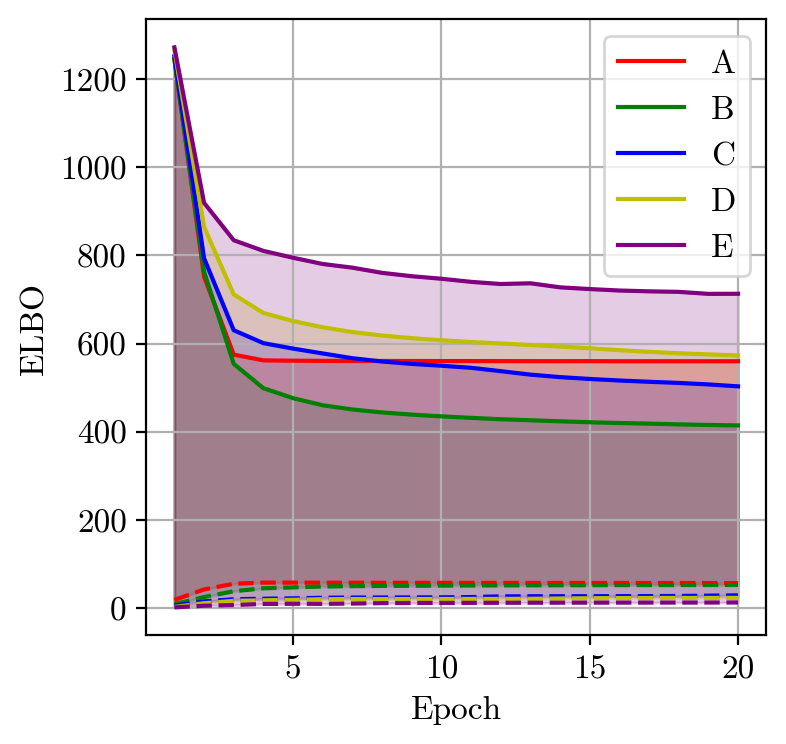

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=200)

plot_colors = ['r', 'g', 'b', 'y', 'purple', 'orange']


x_axis = np.arange(epochs) + 1
# nelbo = kl_div - logx
for name, color in zip(models, plot_colors):
    nelbo, kl_div = train_data[name]
    plt.plot(x_axis, nelbo, color=color, label=name)
    plt.plot(x_axis, kl_div, '--', color=color)
    plt.fill_between(x_axis, kl_div, nelbo, color=color, alpha=0.2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.grid(True)
save_jpg('figures/elbo.jpg')

### Plot reconstructed images (exact decoding, i.e. no resampling)

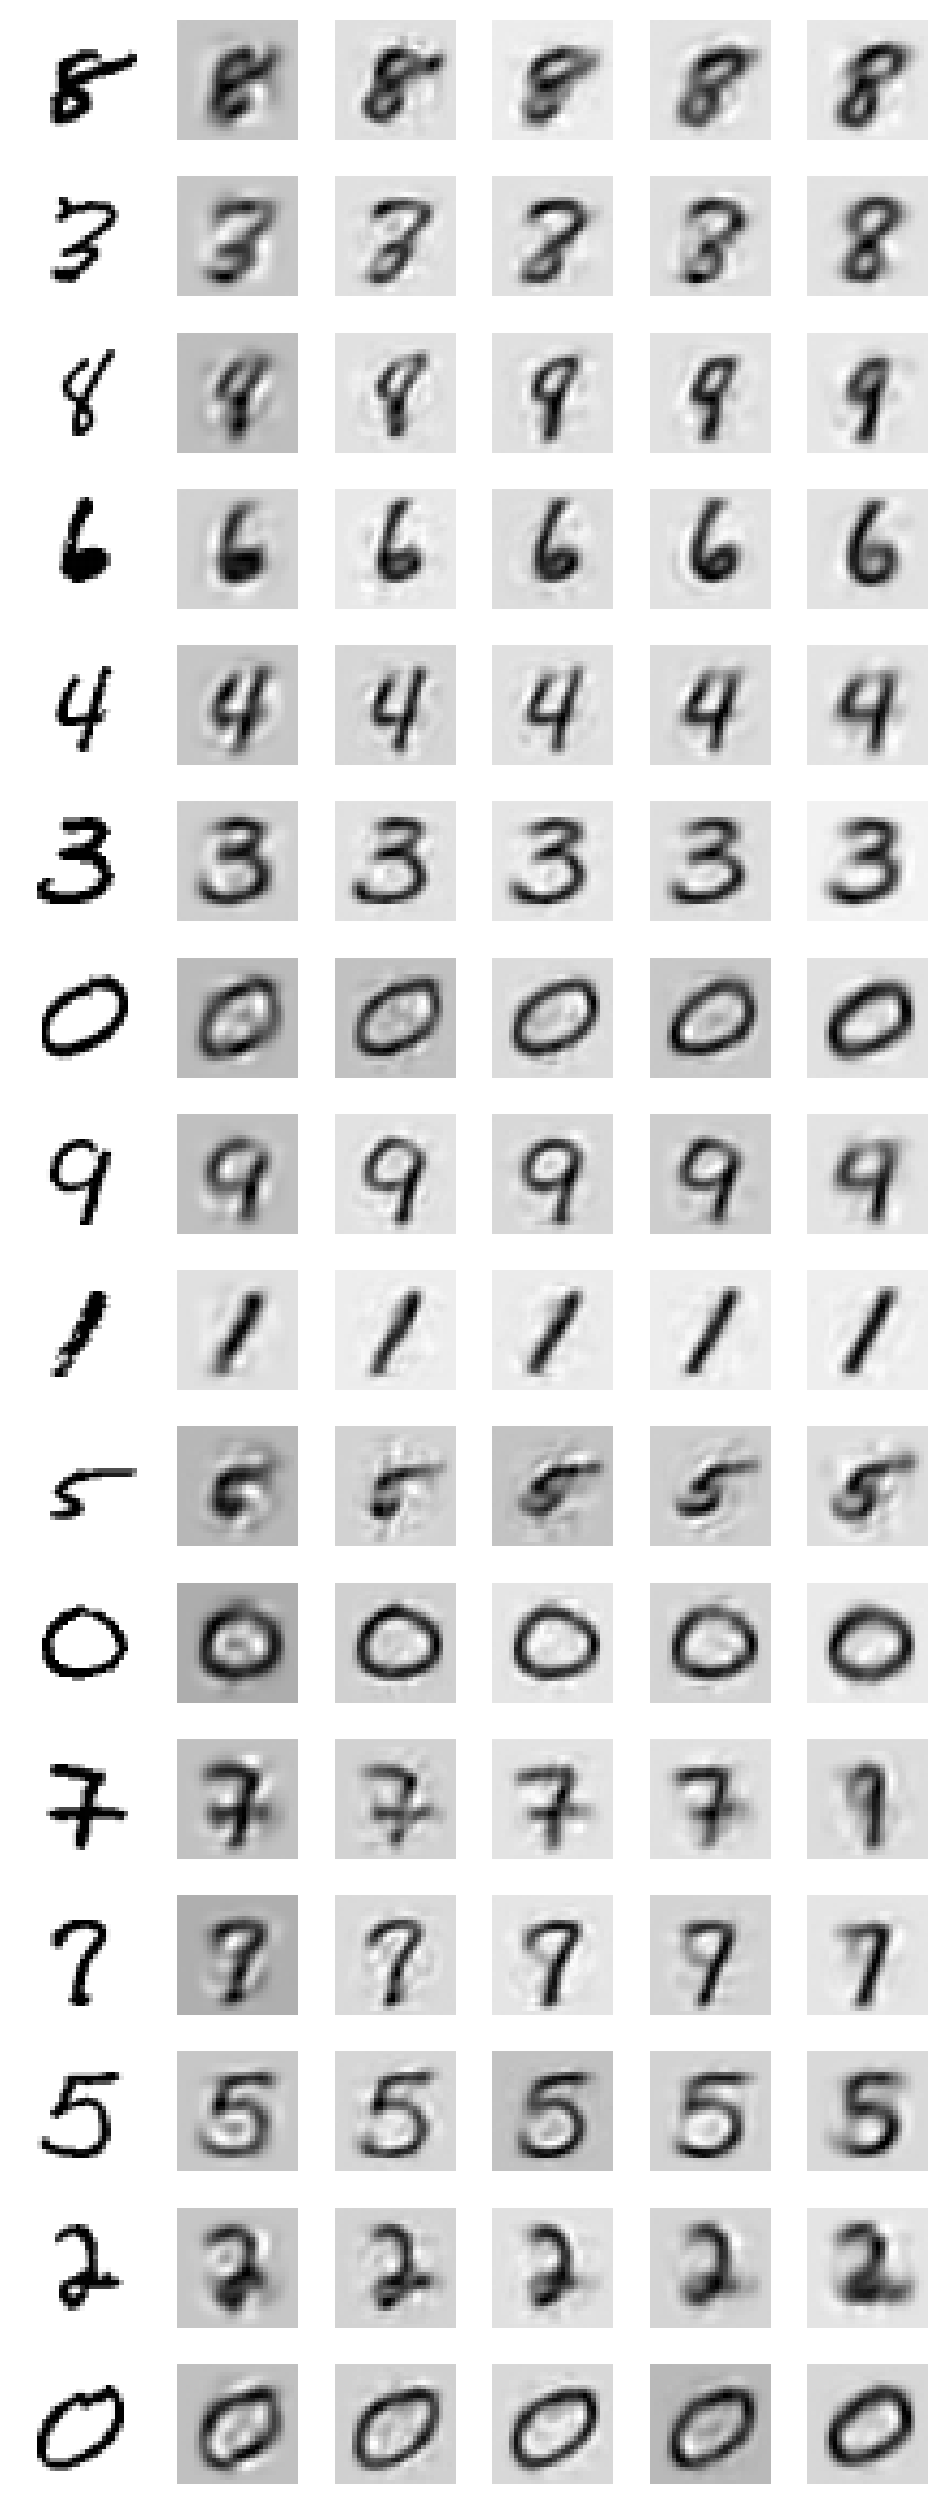

In [ ]:
batch_size = 16
batch_indices = np.random.choice(len(test_set), size=batch_size, replace=False)
batch =  test_set[batch_indices][0]

nrows = batch_size
ncols = len(models) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=200, figsize=(6,16))


images = [[None for _ in range(ncols)] for _ in range(nrows)]

# Original images
for i in range(batch_size):
    images[i][0] = batch[i]

# for each model:
for column, vae in enumerate(models.values(), start=1):
    z_mu, z_sigma = vae.encoder(batch)
    qz = dstr.Normal(z_mu, z_sigma)
    # sample with re-parametrization
    z = qz.rsample()
    x = vae.decoder(z_mu)

    for i in range(batch_size):
        images[i][column] = x[i]

for i, j in itertools.product(range(nrows), range(ncols)):
    show_image(images[i][j], axs[i, j])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
save_jpg('figures/exact-decoding.jpg')


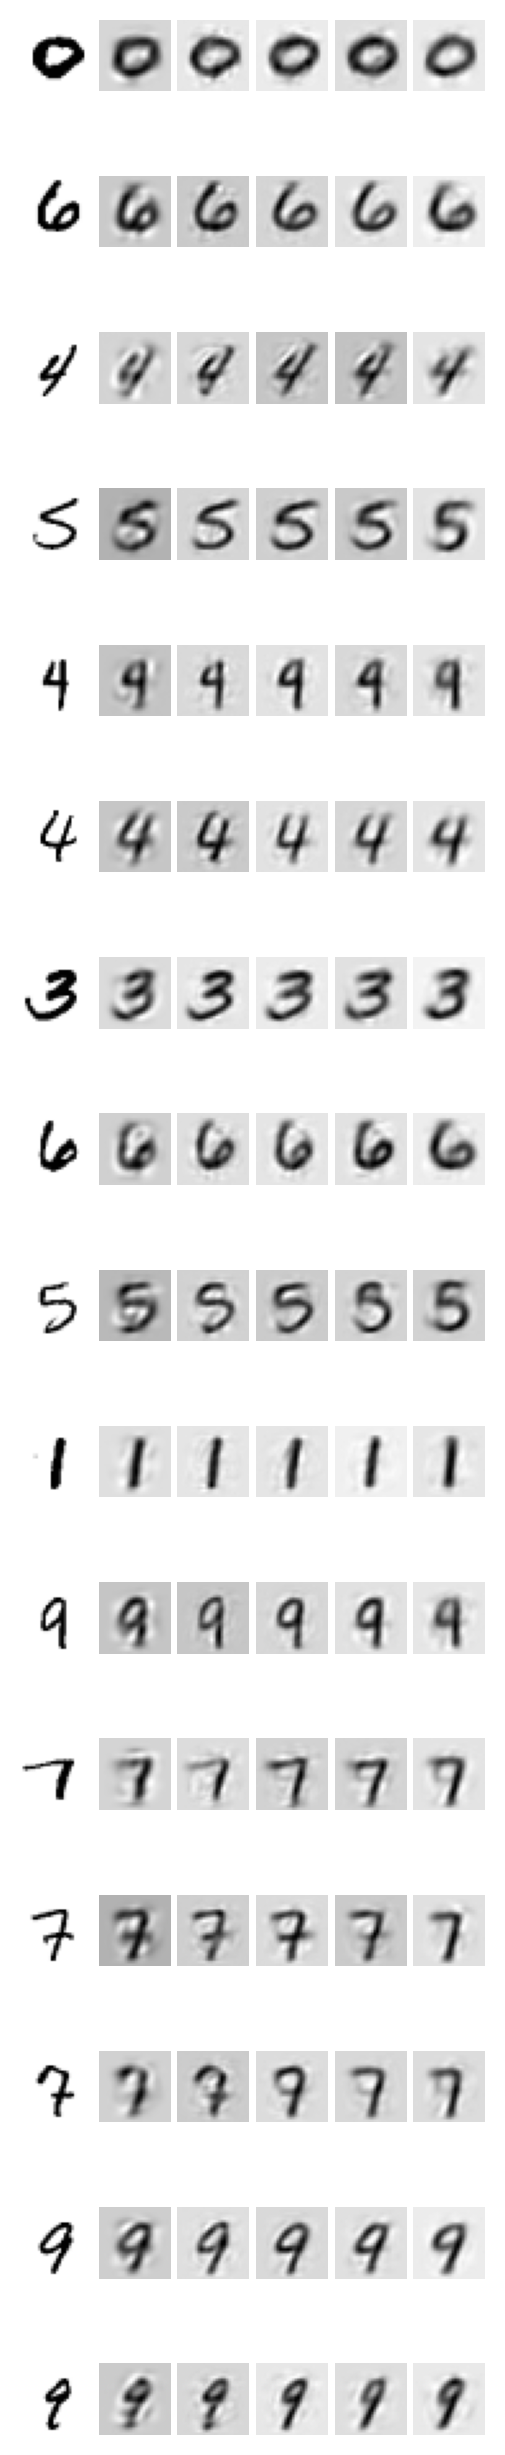

In [ ]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=200, figsize=(6,16))

images = [[None for _ in range(ncols)] for _ in range(nrows)]

# Original images
for i in range(batch_size):
    images[i][0] = batch[i]

# for each model:
for column, vae in enumerate(models.values(), start=1):
    z_mu, z_sigma = vae.encoder(batch)
    qz = dstr.Normal(z_mu, z_sigma)
    # sample with re-parametrization
    z = qz.rsample()
    x = vae.decoder(z)

    for i in range(batch_size):
        images[i][column] = x[i]

for i, j in itertools.product(range(nrows), range(ncols)):
    show_image(images[i][j], axs[i, j])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
save_jpg('figures/noisy-decoding.jpg')


## Assignment 3

### Final values of ELBO for individual models:

In [ ]:
print('Model name & Terminal ELBO \\\\ \\hline')
for name in models:
    print(f'{name} & {train_data[name][0][-1]:.1f}')

A & 559.8838500976562
B & 414.3228454589844
C & 502.97149658203125
D & 573.128662109375
E & 712.9923706054688


### Posterior collapse

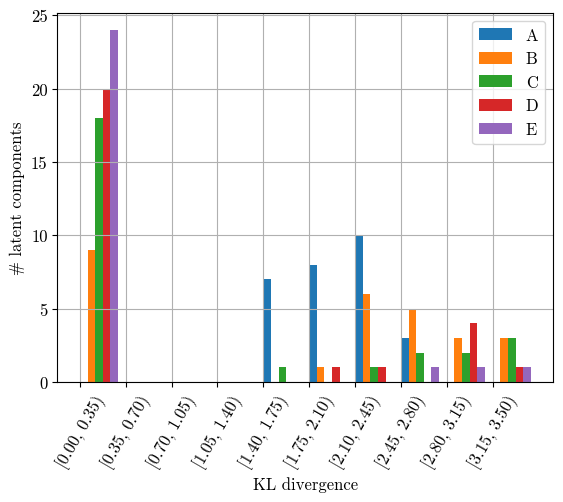

In [ ]:
batch_size = 256
batch_indices = np.random.choice(len(test_set), size=batch_size, replace=False)
batch =  test_set[batch_indices][0]

kl_div = {}
for j, (name, vae) in enumerate(models.items()):
    z_mu, z_sigma = vae.encoder(batch)
    kl_div[name] = []
    for i in range(zdim):
        # 1D distribution for i-th latent variable
        qz = dstr.Normal(z_mu[:, i], z_sigma[:, i])
        pz = dstr.Normal(torch.zeros((batch_size,)), torch.ones((batch_size,)))
        kl = dstr.kl_divergence(qz, pz)
        kl_div[name] += [kl.mean(0).detach().item()]

    data, edges = np.histogram(kl_div[name], range=(0, 3.5))
    width = 1 / (len(models) + 1) * (edges[1] - edges[0])
    plt.bar(edges[:-1] + (j+0.5)*width, data, width= width, label=name)
plt.ylabel('# latent components')
plt.xlabel('KL divergence')
xticks = [(left, f'[{left:.2f}, {right:.2f})') for left, right in zip(edges[:-1], edges[1:])]
plt.xticks(ticks=[center for center, label in xticks], labels=[label for center, label in xticks], rotation=60)
plt.legend()
plt.grid()
save_jpg('figures/posterior-collapse.jpg')


### Evaluating the decoder
get batch_size samples from N(0, 1)

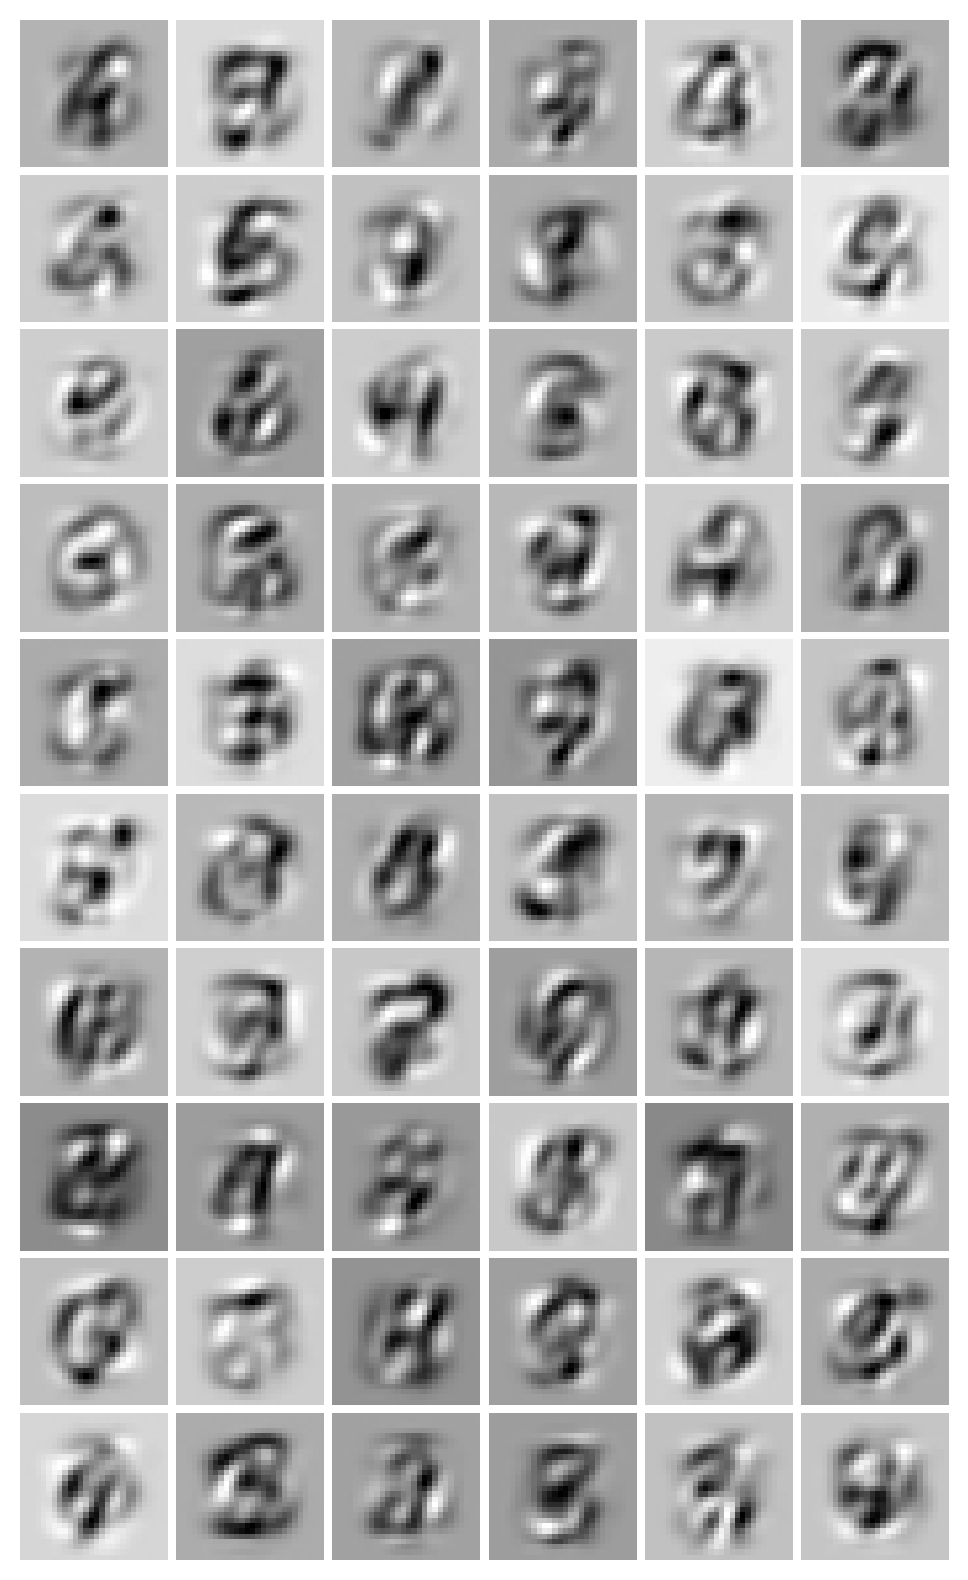

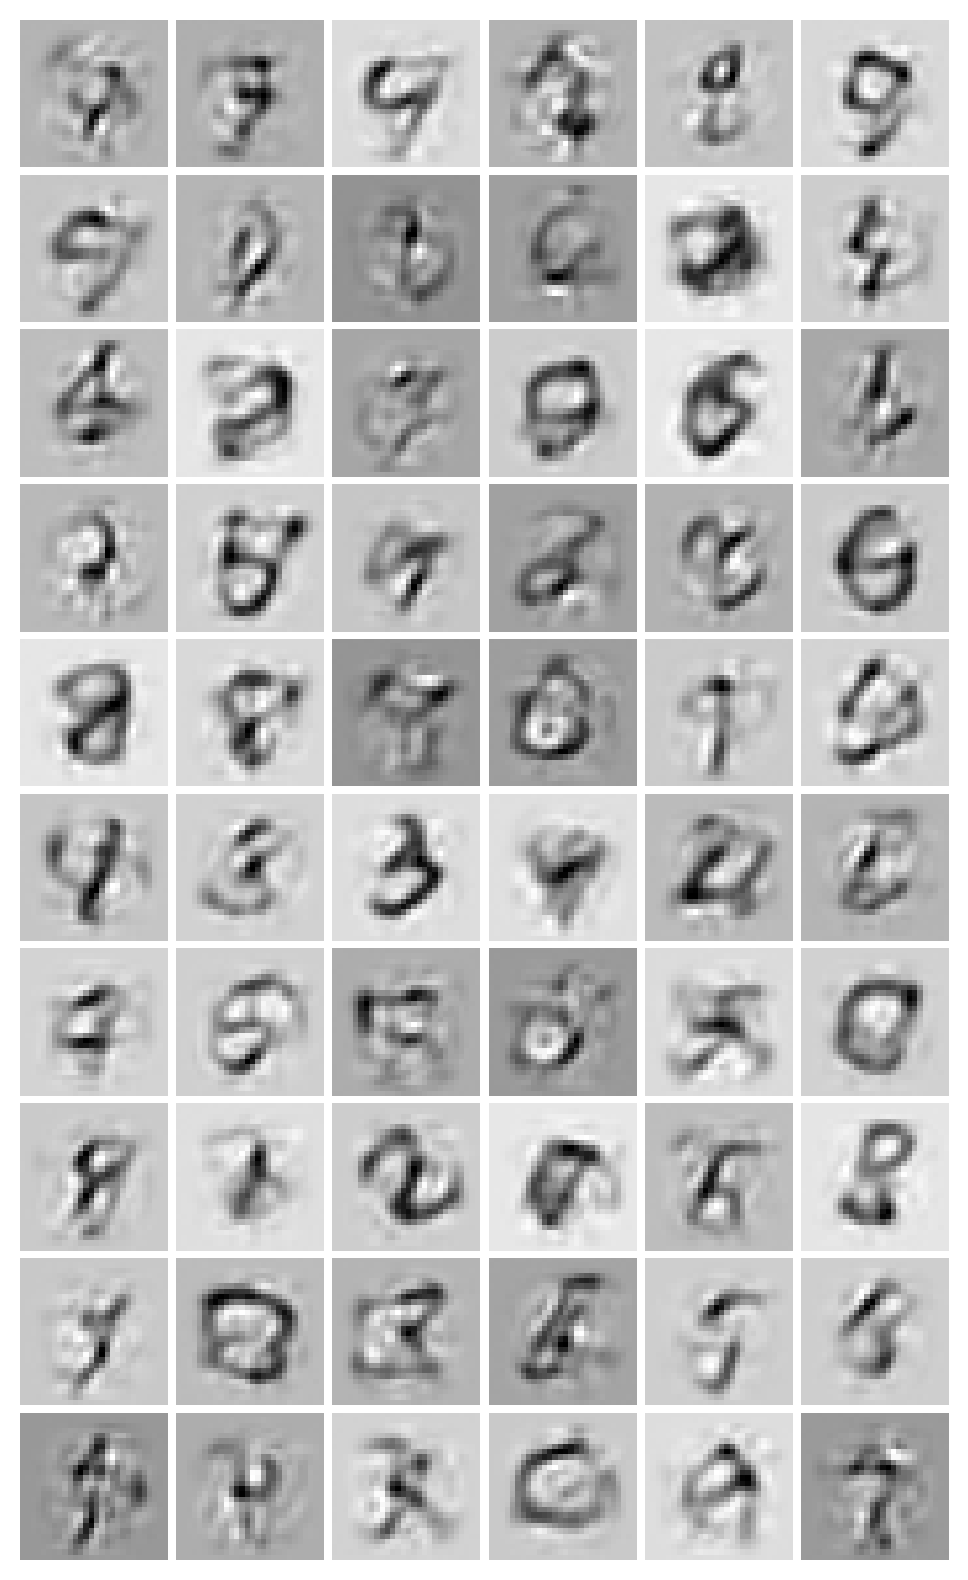

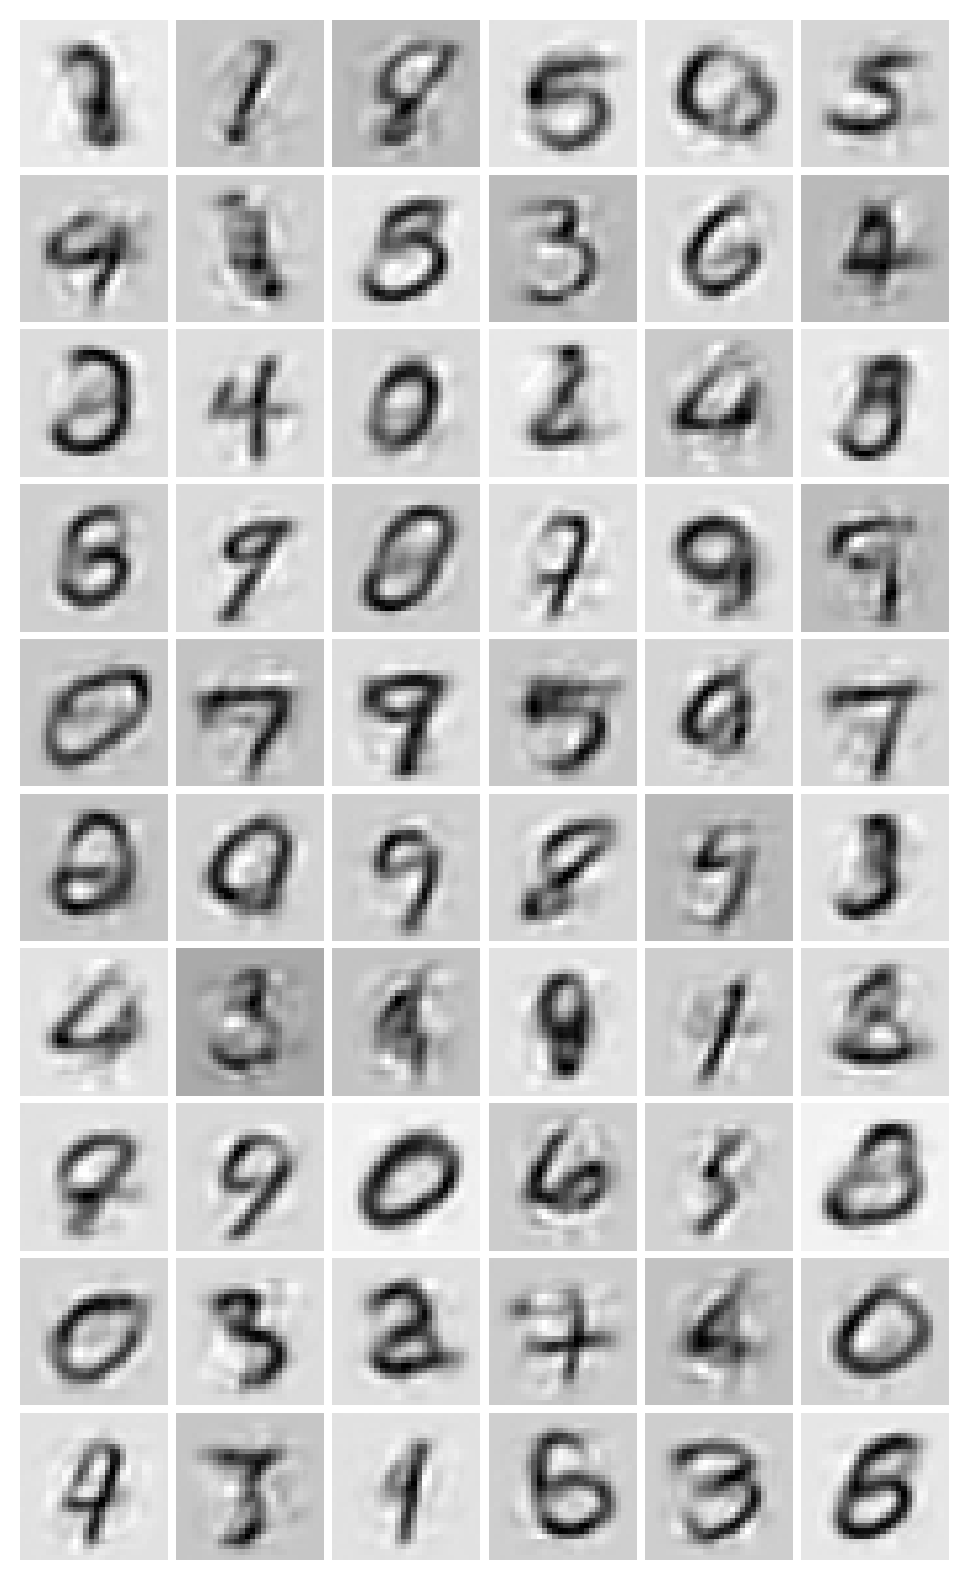

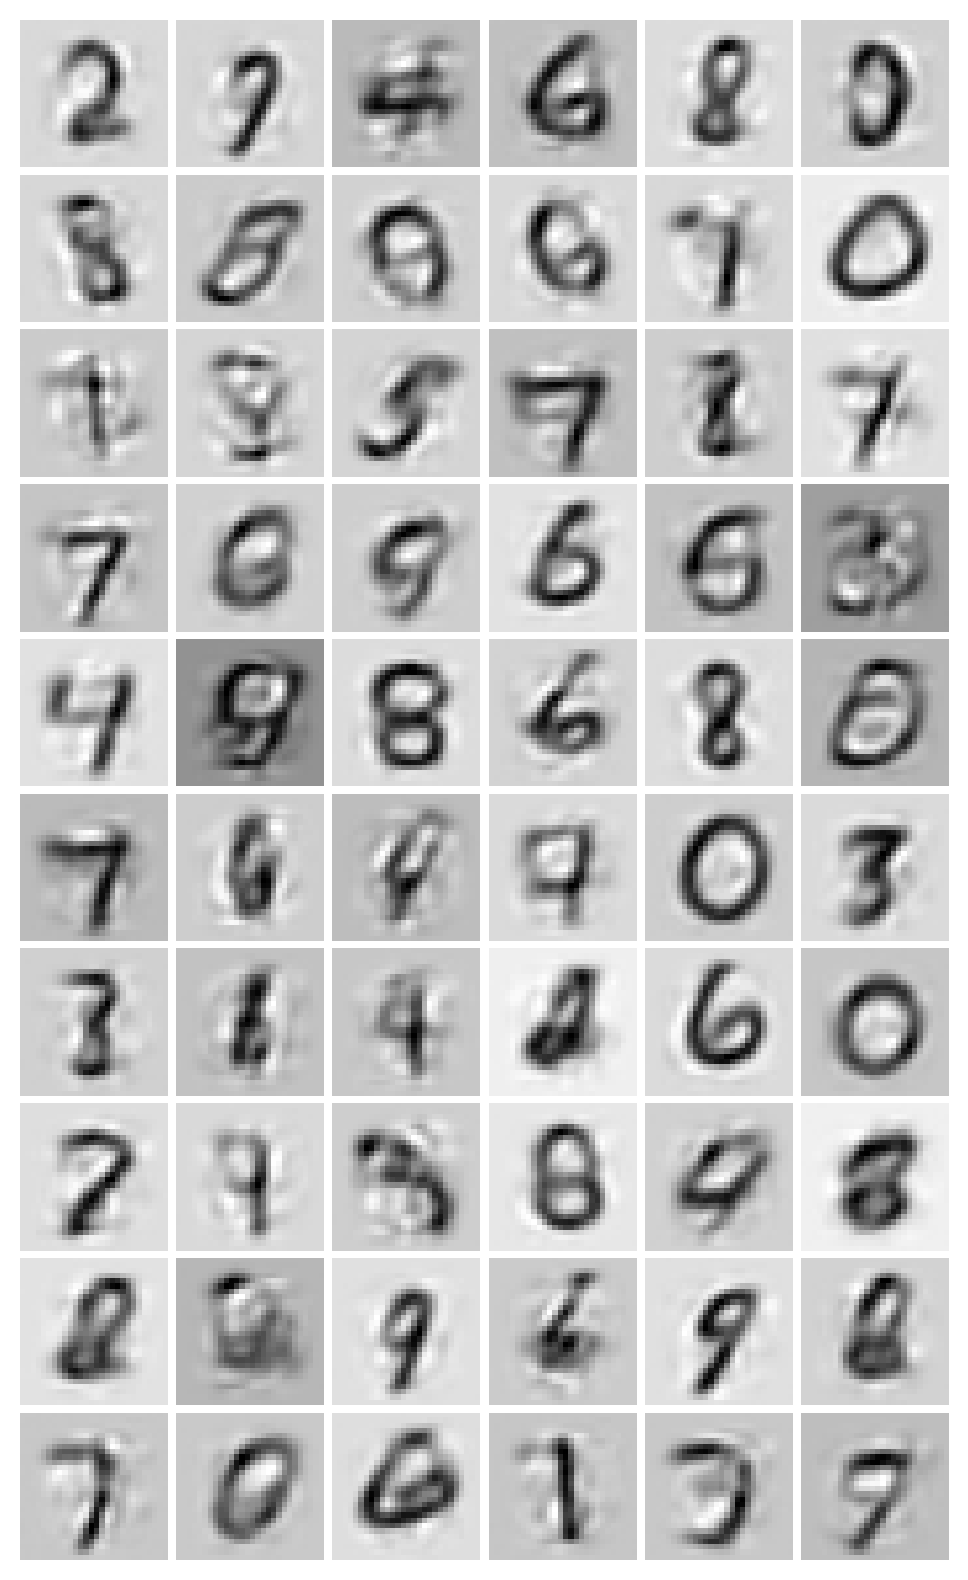

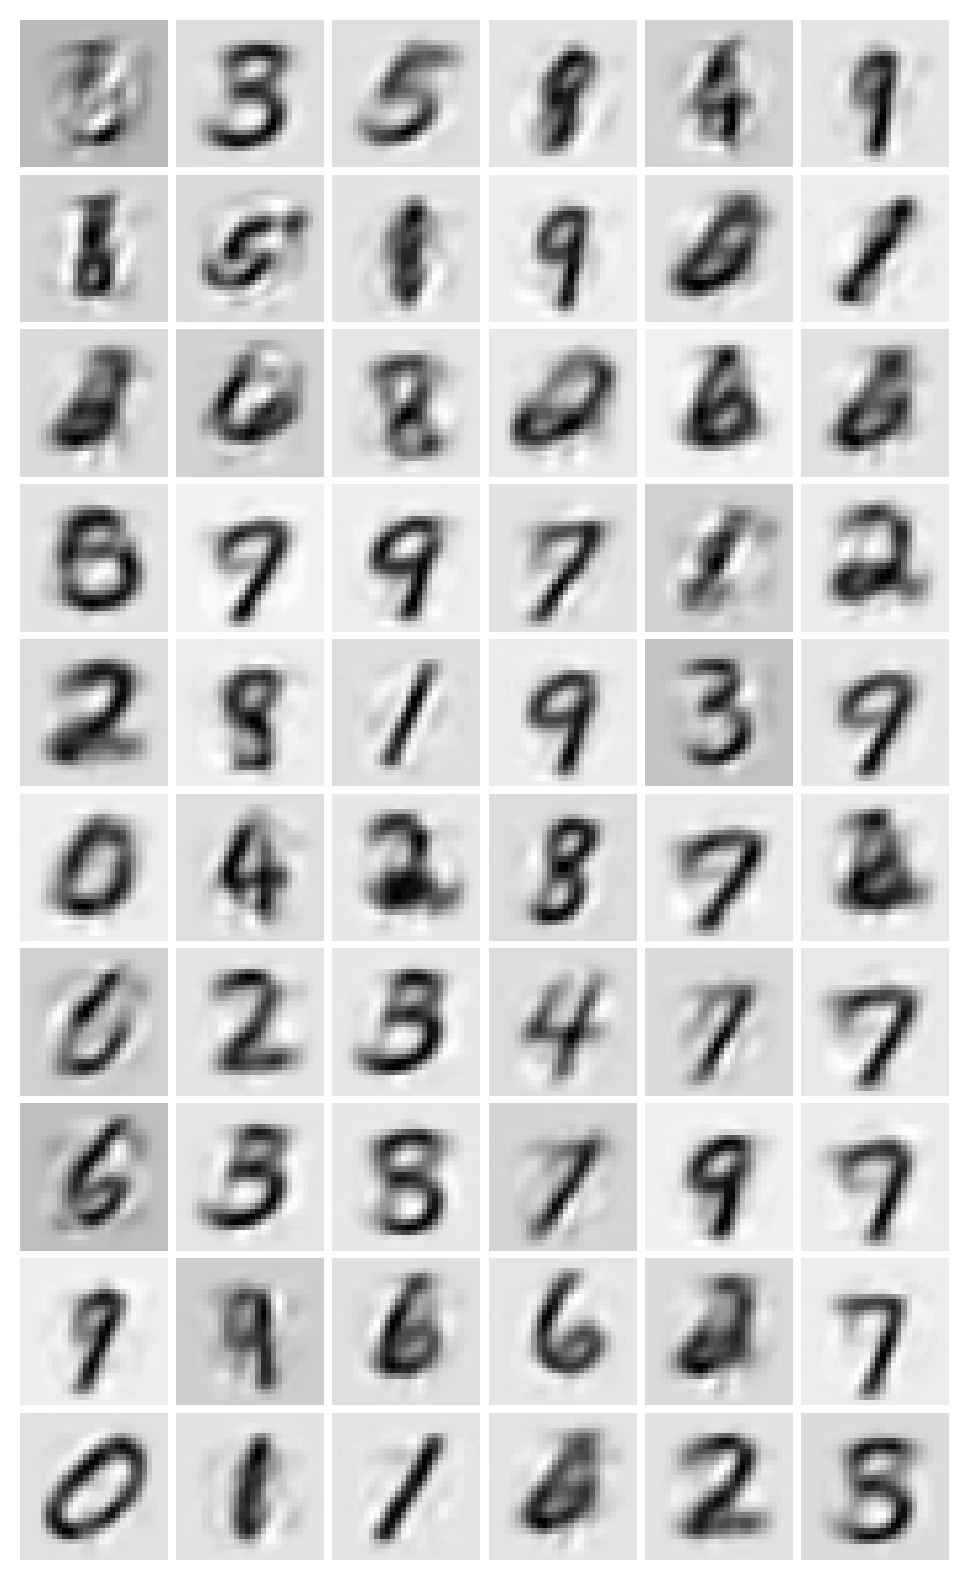

In [ ]:
batch_size = 60
pz = dstr.Normal(torch.zeros((batch_size,zdim)), torch.ones((batch_size,zdim)))
z_batch = pz.rsample()

def plot_random_images(name, vae):
    fig, axs = plt.subplots(nrows=10, ncols=6, dpi=200, figsize=(6, 10))

    images = [[None for _ in range(ncols)] for _ in range(nrows)]

    x_batch = vae.decoder(z_batch)

    for i, x in enumerate(x_batch):
        show_image(x, axs.flat[i])

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    save_jpg(f'figures/random-z-{name}.jpg')

for name, vae in models.items():
    plot_random_images(name, vae)

### Limiting distribution

In [ ]:
batch_size = 60
pz = dstr.Normal(torch.zeros((batch_size,zdim)), torch.ones((batch_size,zdim)))
z_batch_start = pz.rsample()

x_batch = None
images = []
axs = None

# Update function for animation
def update_animation(frame):
    global x_batch
    global images
    global axs
    # start from the x from previous iteration.
    px = dstr.Normal(x_batch, torch.exp(vae.decoder.logsigma))
    # Sample a new one
    x_batch = px.rsample()
    # Encode it to get z 
    z_mu, z_sigma = vae.encoder(x_batch)
    qz = dstr.Normal(z_mu, z_sigma)
    # Sample a new z
    z_batch = qz.rsample()
    # get the next image batch
    x_batch = vae.decoder(z_batch)

    for i, x in enumerate(x_batch):
        show_image(x, axs.flat[i])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    print(f'Update {frame}')
    return images

def plot_limiting_distribution(name, vae, num_frames):
    ncols = 10
    nrows = 6
    global x_batch
    global images
    global axs
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    x_batch = vae.decoder(z_batch_start)
    for i, x in enumerate(x_batch):
        images += [show_image(x, axs.flat[i])]

    # Create the animation
    ani = animation.FuncAnimation(fig, update_animation, frames=num_frames, interval=200, blit=True)

    # Save the animation as an mp4 file (optional)
    ani.save(f'animation-{name}.gif', writer=animation.PillowWriter(fps=5))

    # Display the animation
    #plt.show()

for name, vae in models.items():
    plot_limiting_distribution(name, vae, 100)

NameError: name 'dstr' is not defined